## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [100]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [101]:
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

b. Use the below cell to find the number of rows in the dataset.

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [103]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [104]:
#proportion of users converted
(df['converted'].mean())

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [105]:
# no of times new page and treatment don't match
df.query('(group=="treatment" and landing_page !="new_page") or (group=="control" and landing_page =="new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [106]:
df.isnull().sum() #no missing value

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [107]:
# remove unused data and store new df in df2
df2 = df.drop(df.query('(group=="treatment" and landing_page!="new_page") or (group=="control" and landing_page=="new_page")').index)

In [108]:
# Double Check all of the correct rows were removed, should = 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [109]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [110]:
df2[df2.duplicated('user_id', keep=False) == True]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

c. What is the row information for the repeat **user_id**? 

In [111]:
repeat = df2[df2.user_id.duplicated()]
repeat

user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [112]:
df2.drop(df.index[2893], axis=0, inplace=True)

In [113]:
#confirmation of no duplicates
df2.user_id.duplicated().sum()

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [114]:
(df2['converted'].mean())

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [115]:
(df2.query("group == 'control'")['converted'].mean())

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [116]:
(df2.query("group == 'treatment'")['converted'].mean())

0.11880806551510564

d. What is the probability that an individual received the new page?

In [117]:
(df2.query("landing_page == 'new_page'").user_id.count() / df2.shape[0])

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Overall conversions: 11.96%<br>
Control (old page) conversions: 12.04%<br>
Treatment (new page) conversions: 11.88%<br>

No, there is no sufficient evidence to conclude that the new page leads to more conversions. With a difference of 0.2%,This difference is small. 
There is need for more testing.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{new} \leq p_{old} $$
$$ H_1: p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [118]:
p_new = (df2['converted'].mean())
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [119]:
p_old = (df2['converted'].mean())
p_old

0.11959708724499628

c. What is $n_{new}$?

In [120]:
n_new = df2.query("landing_page == 'new_page'").shape[0]
n_new

145310

d. What is $n_{old}$?

In [121]:
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [122]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted.mean()

0.12011561489229922

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [123]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.12163222600052315

In [124]:
simulated_diff = new_page_converted.mean() - old_page_converted.mean()
simulated_diff.mean()

-0.0015166111082239309

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [125]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append((new_page_converted/n_new) - (old_page_converted/n_old))

In [126]:
#convert to numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

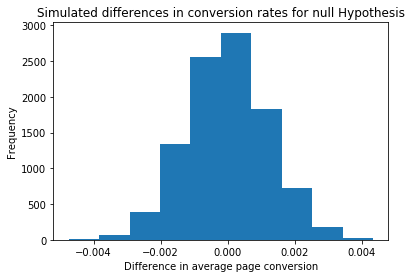

In [127]:
plt.hist(p_diffs)
plt.title("Simulated differences in conversion rates for null Hypothesis")
plt.xlabel("Difference in average page conversion")
plt.ylabel("Frequency");

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [128]:
new_actual_conv = df2.query('landing_page == "new_page"')['converted'].mean()
old_actual_conv = df2.query('landing_page == "old_page"')['converted'].mean()
obs_diff = new_actual_conv - old_actual_conv
obs_diff

-0.0015782389853555567

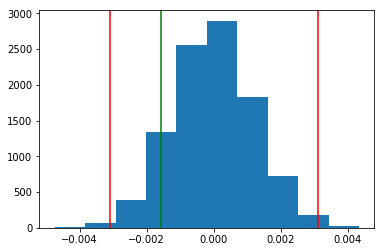

In [129]:
p_diffs = np.array(p_diffs)

# view 99% confidence interval
lower, upper = np.percentile(p_diffs, .5), np.percentile(p_diffs, 99.5)

plt.hist(p_diffs)
plt.axvline(x=lower, color= 'r')
plt.axvline(x=upper, color='r')
plt.axvline(obs_diff, color='green');

In [130]:
print("Actual observed difference is:", obs_diff)

Actual observed difference is: -0.0015782389853555567


In [131]:
# proportion of p_diffs greater than the observed difference in ab_data.csv
print("Proportion of p_diffs greater than the observed difference is:", (p_diffs > obs_diff).mean())

Proportion of p_diffs greater than the observed difference is: 0.9047


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

### Alternative hypothesis says p_new > p_old. 

When we view the above distribution, we can observe that the line in green(to the right) is more than half of the distribution which tells us that our observed statistic falls within this range. Which then supports our null hypothesis that the old page converts >= the new page.


### This is p-value.

A p-value is the probability of getting the results you did (or more extreme results) given that the null hypothesis is true.
so a very large p-value indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis which suggest the new page conversion rate is higher than the old rate.

Type I error: Deciding the new page (alt) is better, but really the old page (null) is better.

Type II error: Deciding the old page (null) is better, but really the new page (alt) is better.

Type I error threshold: 0.05

If p-value <= 0.05: Then we have a strong evidence against the null, so we should (reject the null)

If p-value > 0.05 : Then we have a weak evidence against the null, so we should (fail to reject the null)

### In this case our pvalue is large 0.9027, which means we do NOT have statistically significent evidence that tells us the new page converts better. 

### Knowing this we therefore, fail to reject the null and continue using the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [132]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

(convert_old, convert_new, n_old, n_new)

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [133]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [134]:
from scipy.stats import norm

# Tells us how significant our z-score is
print(norm.cdf(z_score))

# Tells us what our critical value at 95% confidence
print(norm.ppf(1-(0.05/2))) 

0.9050583127590245
1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

### The z-score of 1.31 does not exceeds the critical value of 1.959963984540054.

>This tells us that the z-score and p-value agree with the findings in parts j and k - there is no clear difference in the conversions of each page, and we cannot reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [135]:
#Create dummy variables and add an intercept
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   ab_page  old_page  intercept  
0        0         1          1  
1        0         1          1  
2        1         0          1  
3        1         0          1  
4        0         1          1

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [136]:
import statsmodels.api as sm

# create a logistic regression model using intercept and ab_page column
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [137]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 25 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        21:33:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [138]:
1/np.exp(-0.0150)

1.015113064615719

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The ab_page p-value is 0.190. It is larger than our Type 1 error rate of .05, which tells us that the landing page is not statistically significant in predicting whether the viewer converts or not.

The big difference is, this is a two-tailed test and in Part II was one tailed test.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Age group limitations could influence whether or not an individual converts to new page or not. It is imporant to note what is good for our model. Sometimes adding too many factors could complicate the model making it hard to interprete properly.

Something i would add is a timestamp, to let me know the time and day conversion takes place more.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [139]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  ab_page  old_page  intercept  
user_id                                           
834778           0        0         1          1  
928468           0        1         0          1  
822059           1        1         0          1  
711597           0        0         1          1  
710616           0        1         0          1

In [140]:
countries_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [141]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  ab_page  old_page  intercept  CA  UK  US  
user_id                                                       
834778           0        0         1          1   0   1   0  
928468           0        1         0          1   0   0   1  
822059           1        1         0          1   0   1   0  
711597           0        0         1          1   0   1   0  
710616           0        1         0          1   0   1   0

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [142]:
### Fit Your Linear Model And Obtain the Results
logit2 = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = logit2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 25 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        21:33:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [143]:
1/np.exp(-0.0408), np.exp(0.0099)

(1.0416437559600236, 1.0099491671175422)

> ### As we can see all p-values are greater than our Type 1 error rate of 0.05, which tells us country does not have a significant impact on conversion.

Having this in mind, I want to know if there's an interaction that would prove significant effect on conversion between page and country

In [144]:
#Creates a new interacton variable between page and country
df_new['CA_page'] =  df_new['ab_page'] * df_new['CA']
df_new['UK_page'] =  df_new['ab_page'] * df_new['UK']
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  ab_page  old_page  intercept  CA  UK  US  CA_page  UK_page  
user_id                                                                         
834778           0        0         1          1   0   1   0        0        0  
928468           0        1         0          1   0   0   1        0        0  
822059           1        1         0          1   0   1   0        0        1  
711597           0        0         1          1   0   1   0        0        0  
710616           0        1         0          1   0   1   0        0        1

In [145]:
#Create logistic regression for the intereaction variable between new page and country using dummy variable
logit3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_page', 'UK_page']])
result = logit3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 25 Jan 2019   Pseudo R-squ.:               3.482e-05
Time:                        21:33:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_page       -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_page        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [146]:
1/np.exp(-0.0206), 1/np.exp(-0.0175), 1/np.exp(-0.0057), 1/np.exp(-0.0469), np.exp(0.0314)

(1.020813644503746,
 1.0176540221507617,
 1.0057162759095335,
 1.048017202119183,
 1.0318981806179213)

For every unit decrease in  ab_page, conversion is 1.02% more likely to take place, holding all other varible constant.

For every unit decrease in CA conversion is 1.01% more likely to take place for users in CA than US, holding all other varible constant.

For every unit decrease in UK conversion is 1.02% more likely to take place for the users in UK than US, holding all other varible constant.

For every unit decrease in CA_page, conversion is 1.04% more likely to take place for CA new page users than US new page users, holding all other varible constant.

For every unit increase in UK_page, conversion is 1.03% more likely to take place for UK new page users than US new page users, holding all other varible constant.


> ### The results shows the interaction between page and country has no impact on the conversion rate because all of the p-values are still larger than our type 1 error rate of 0.05. It doesn't affect our conversion rate

> ### Our results tells us we do not have sufficient evidence to suggest that the new page rakes in more conversions than the old page.

Note: All results and insights are all based on the data provided.

Limitations: The only limitation i really noticed is that some factors were not added to the data.

Resources: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8